In [125]:
# Importing necessary Libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [127]:
# Variable that sets the file path for the dataset.

file_path = '/Users/tony/Downloads/Multi-Class(Pens,Mechanical,Wooden)'




In [128]:
# Variables that set the file path for the dataset.

file_path_img = file_path

# Variables that are used in the training stage of the model.

learning_rate = 0.00013
BATCH_SIZE = 16
num_of_epochs = 10

In [131]:
# Pre-Processing Stage


# Defining the resizing and conversion of images from the dataset.

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split



transform = transforms.Compose([
    transforms.Resize((320, 320)), # Resize to model input size 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# Loading the dataset

dataset = datasets.ImageFolder(file_path_img,
                               transform=transform)

# Accessing the images from the training set

train_set = datasets.ImageFolder(
    file_path_img + '/Train',  
    transform=transform
)

# Accessing the images from the validation set

validatation_set = datasets.ImageFolder(
    file_path_img + '/Validation', 
    transform=transform
)

# Accessing the images from the test set

test_set = datasets.ImageFolder(
    file_path_img + '/Test',  
    transform=transform
)

# Create DataLoaders

# Loading the images from the training set 

train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True)

# Loading the images from the validation set 

validatation_loader = DataLoader(validatation_set, BATCH_SIZE, shuffle=True)

# Loading the images from the test set 

test_loader = DataLoader(test_set,BATCH_SIZE, shuffle=False)

# Putting all of these loaders into one dictionary

loaders = {'train':train_loader,
          'validation': validatation_loader,
          'test': test_loader
}



class_name = train_set.classes
class_total = len(class_name)

In [ ]:
# Defining a ResNet18 model using Transfer Learning. 


model = torchvision.models.resnet34(weights=True)
model.fc = nn.Linear(model.fc.in_features,4)

In [134]:
# Defining the Validation and Training Stages

# Checking the GPU is availabe, if not then use CPU

device = ''
if (torch.cuda.is_available()):
  device = 'cuda'
else:
  device = 'cpu'

# Defining the optimizer and loss function for the model


optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate ,weight_decay=0.00001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

loss_fn = nn.CrossEntropyLoss()

def validate(model,val_loader,loss_fn):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    val_loss /= len(val_loader)
    accuracy = 100. * correct / total

    return val_loss, accuracy

def train(model,epochs,patience=5):
    best_val_loss = float('inf')
    best_model_weights = None
    epochs_no_improve = 0

    train_accuracy_list = []
    val_accuracy_list = []
    train_loss_list = []
    val_loss_list = []
    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(loaders['train']):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} '
                      f'({100. * batch_idx / len(loaders["train"]):.0f}%)]\tLoss: {loss.item():.6f}')

        # Validation phase
        val_loss, val_acc = validate(model, loaders['validation'], loss_fn)
        train_loss /= len(loaders['train'])
        train_acc = 100. * correct / total

        train_accuracy_list.append(train_acc)
        val_accuracy_list.append(val_acc)

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        
        print(f'\nEpoch {epoch}:')
        print(f'Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%')

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Validation loss improved. Model saved.')
        else:
            epochs_no_improve += 1
            print(f'No improvement in validation loss for {epochs_no_improve} epochs')
            if epochs_no_improve >= patience:
                print(f'Early stopping after {epoch} epochs')
                break

    plt.plot(train_accuracy_list,label= 'Train Accuracy')
    plt.plot(val_accuracy_list,label= "Validation Accuracy")
    plt.title("Train & Validation Accuracy")
    plt.xlabel("epocs")
    plt.ylabel("Accuracy(%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.plot(train_loss_list,label="Training Loss")
    plt.plot(val_loss_list,label= "Validation Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy(%)")
    plt.legend()
    plt.tight_layout()


    plt.show()
    # Load best model weights
    model.load_state_dict(best_model_weights)
    return model


In [135]:
# Defining the Test Stage

def test_model(model, test_loader, print_samples=5):
    model.eval()
    class_names = test_loader.dataset.classes
    num_classes = len(class_names)

    # Initialize counters
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    confusion_matrix = torch.zeros(num_classes, num_classes)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Update confusion matrix
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

            # Update per-class accuracy
            for label, prediction in zip(labels, predicted):
                class_total[label] += 1
                if label == prediction:
                    class_correct[label] += 1

    # Calculate overall and per-class accuracy
    total_correct = sum(class_correct)
    total = sum(class_total)
    overall_accuracy = 100 * total_correct / total

    print("\nClass-wise Performance:")
    print("-" * 50)
    for i in range(num_classes):
        accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"{class_names[i]:<15}: {accuracy:.2f}% ({class_correct[i]}/{class_total[i]})")

    print("-" * 50)
    print(f"\nOverall Accuracy: {overall_accuracy:.2f}% ({total_correct}/{total})")
    print("-" * 50)

    # Print normalized confusion matrix
    cm_normalized = confusion_matrix / confusion_matrix.sum(1).view(-1, 1)
    print("\nNormalized Confusion Matrix:")
    print(cm_normalized)

    return overall_accuracy, confusion_matrix

In [136]:
# Defining the Confusion Matrix for Evaluation

import matplotlib.pyplot as plt

def create_confusion_matrix_manual(model, test_loader, class_names, device):
    model.eval()
    num_classes = len(class_names)
    confusion_matrix = torch.zeros(num_classes, num_classes)

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            _, preds = torch.max(outputs, 1)

            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    # Normalize the confusion matrix
    cm_normalized = confusion_matrix / confusion_matrix.sum(1).view(-1, 1)

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.imshow(cm_normalized.numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(torch.arange(num_classes),class_names)
    plt.yticks(torch.arange(num_classes),class_names)

    # Add text annotations
    thresh = cm_normalized.max() / 2.
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, f"{confusion_matrix[i, j]:.0f}\n({cm_normalized[i, j]*100:.1f}%)",
                    horizontalalignment="center",
                    color="white" if cm_normalized[i, j] > thresh else "black")

    plt.show()

    return confusion_matrix


In [137]:
# Creating the prediction method for any image

from PIL import Image
import torch
import torch.nn.functional as F
import torchvision

def predict_custom_image(model, image_path, class_names):

    # Set device automatically
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Model setup
    model = model.to(device)
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((320, 320)), 
        transforms.ToTensor(), 
    
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  ])


    try:
        img = Image.open(image_path)
        img = img.convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

        # Prediction
        with torch.no_grad():
            output = model(img_tensor)
            # Apply softmax to get probabilities
            probs = torch.nn.functional.softmax(output[0], dim=0)
            conf, pred_idx = torch.max(probs, 0)

        # Prepare results
        all_probs = {class_names[i]: f"{probs[i].item()*100:.1f}%"
                    for i in range(len(class_names))}

        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted:{class_names[pred_idx]}")
        plt.tight_layout()
        plt.show()
        return class_names[pred_idx], conf.item(), all_probs

    except Exception as e:
        # Re-raise the exception with a more informative message
        raise RuntimeError(f"Prediction failed: {str(e)}")


In [138]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

# Define a dictionary to store layer outputs
layer_outputs = {}

def get_layer_output(name):
    """Hook function to store layer output"""
    def hook(model, input, output):
        layer_outputs[name] = output.detach()
    return hook

def predict_with_debug(model, image_path, class_names):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Register hooks for all layers
    hooks = []
    for name, layer in model.named_children():
        hook = layer.register_forward_hook(get_layer_output(name))
        hooks.append(hook)

    # Preprocess image
        transform = transforms.Compose([
        # transforms.Grayscale(num_output_channels=1), # Ensure 1 channel
        transforms.Resize((320, 320)), # Resize to model input size (or a size appropriate for ResNet)
        transforms.ToTensor(), # Convert PIL Image to PyTorch tensor (1 channel)
        # Duplicate the single channel to 3 channels to match ResNet input expectations
        # (even with the modified conv1, the rest of the network expects 3 channels internally)
        # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        # Normalize with ImageNet means and stds
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # Note: ResNet was originally trained on 224x224 images. Resizing to 128x128 is fine,
        # but you might consider 224x224 if computational resources allow for better performance.
        # The original code used 128x128 in the ModelClassifier __init__, implying this size.
        # Let's stick to 128x128 for now.
    ])


    img = Image.open(image_path)
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Forward pass (captures all layer outputs in `layer_outputs`)
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.nn.functional.softmax(output[0], dim=0)
        conf, pred_idx = torch.max(probs, 0)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Print layer outputs (for debugging)
    for name, output in layer_outputs.items():
        print(f"Layer: {name}")
        print(f"Shape: {output.shape}")
        print(f"Min: {output.min().item()}, Max: {output.max().item()}")
        print("-" * 50)

    # Return prediction results
    all_probs = {class_names[i]: f"{probs[i].item()*100:.1f}%"
                for i in range(len(class_names))}
    return class_names[pred_idx], conf.item(), all_probs

Epoch: 1 [0/392 (0%)]	Loss: 1.495995
Epoch: 1 [160/392 (40%)]	Loss: 0.552389
Epoch: 1 [320/392 (80%)]	Loss: 0.344383

Epoch 1:
Train Loss: 0.6671 | Accuracy: 73.72%
Val Loss: 0.8380 | Accuracy: 63.10%
Validation loss improved. Model saved.
Epoch: 2 [0/392 (0%)]	Loss: 0.142123
Epoch: 2 [160/392 (40%)]	Loss: 0.227990
Epoch: 2 [320/392 (80%)]	Loss: 0.183314

Epoch 2:
Train Loss: 0.3045 | Accuracy: 91.07%
Val Loss: 0.3221 | Accuracy: 89.29%
Validation loss improved. Model saved.
Epoch: 3 [0/392 (0%)]	Loss: 0.033693
Epoch: 3 [160/392 (40%)]	Loss: 0.111241
Epoch: 3 [320/392 (80%)]	Loss: 0.075228

Epoch 3:
Train Loss: 0.1592 | Accuracy: 94.64%
Val Loss: 0.2783 | Accuracy: 88.10%
Validation loss improved. Model saved.
Epoch: 4 [0/392 (0%)]	Loss: 0.185311
Epoch: 4 [160/392 (40%)]	Loss: 0.067157
Epoch: 4 [320/392 (80%)]	Loss: 0.049060

Epoch 4:
Train Loss: 0.1245 | Accuracy: 95.15%
Val Loss: 0.2468 | Accuracy: 90.48%
Validation loss improved. Model saved.
Epoch: 5 [0/392 (0%)]	Loss: 0.018751
Epo

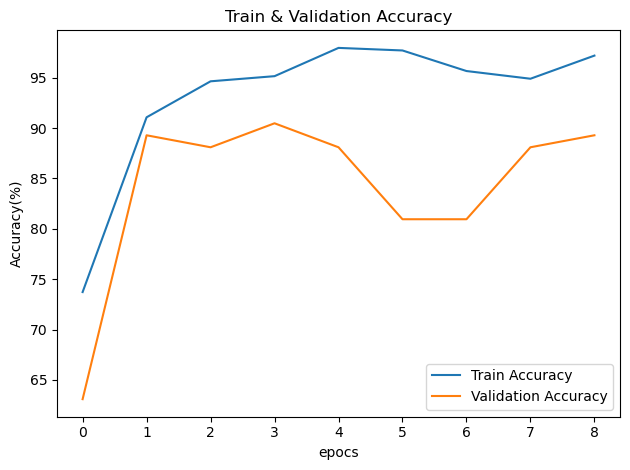

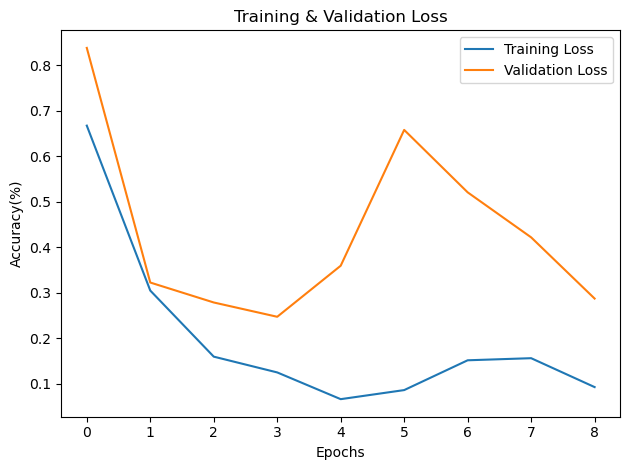

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [139]:
# Training Stage

train(model,num_of_epochs)

In [140]:
# Testing Stage

test_model(model,test_loader)


Class-wise Performance:
--------------------------------------------------
Crayon         : 100.00% (21/21)
Marker         : 66.67% (14/21)
Pen            : 90.48% (19/21)
Wooden_Pencil  : 90.48% (19/21)
--------------------------------------------------

Overall Accuracy: 86.90% (73/84)
--------------------------------------------------

Normalized Confusion Matrix:
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0952, 0.6667, 0.1429, 0.0952],
        [0.0476, 0.0000, 0.9048, 0.0476],
        [0.0476, 0.0000, 0.0476, 0.9048]])


(86.9047619047619,
 tensor([[21.,  0.,  0.,  0.],
         [ 2., 14.,  3.,  2.],
         [ 1.,  0., 19.,  1.],
         [ 1.,  0.,  1., 19.]]))

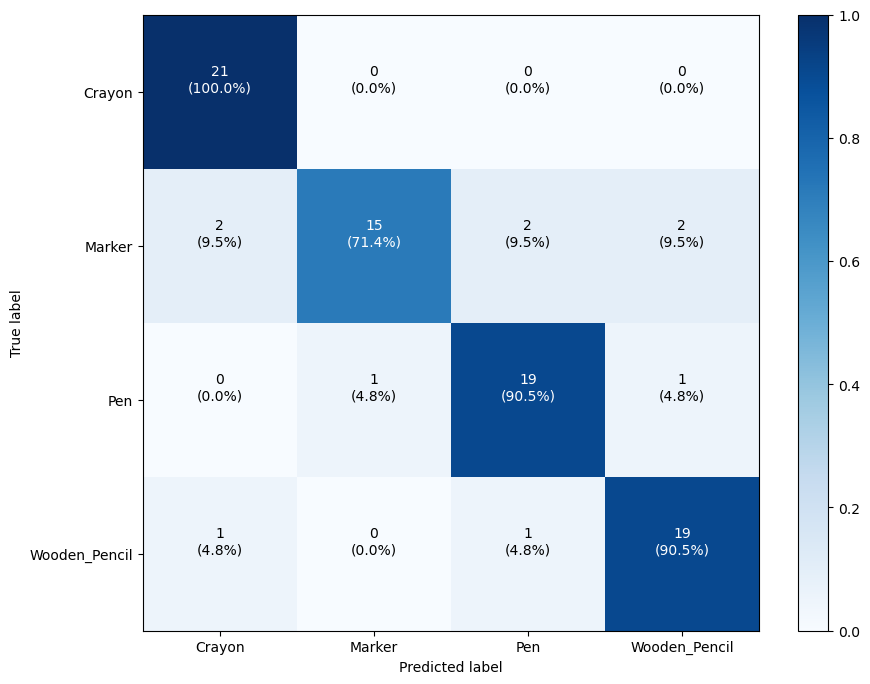

tensor([[21.,  0.,  0.,  0.],
        [ 2., 15.,  2.,  2.],
        [ 0.,  1., 19.,  1.],
        [ 1.,  0.,  1., 19.]])

In [141]:
# Creating the Confusion Matrix

create_confusion_matrix_manual(model,test_loader=test_loader,class_names=class_name,device=device)

Using device: cpu


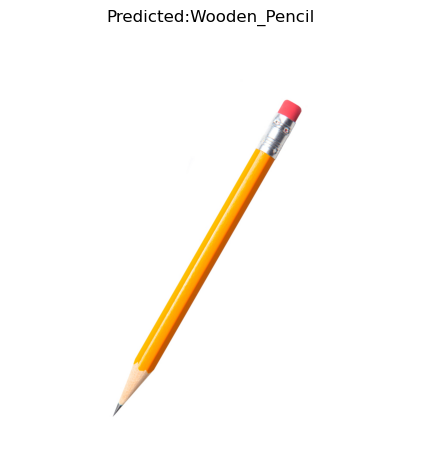


Prediction Results:
Most likely: Wooden_Pencil (72.92% confidence)

All class probabilities:
Crayon: 5.9%
Marker: 1.7%
Pen: 19.5%
Wooden_Pencil: 72.9%


In [144]:
# Prediction Stage 1: Pencil 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Test_images/pencil_280523090.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


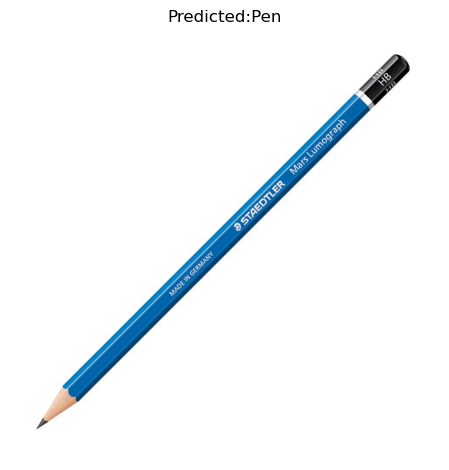


Prediction Results:
Most likely: Pen (99.90% confidence)

All class probabilities:
Crayon: 0.0%
Marker: 0.1%
Pen: 99.9%
Wooden_Pencil: 0.0%


In [145]:
# Prediction Stage 2: Pencil 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Test_images/51TkKa5QdgL.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


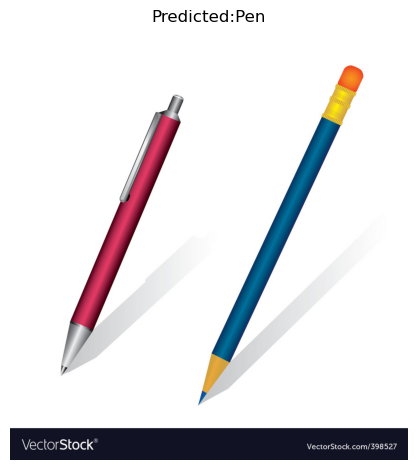


Prediction Results:
Most likely: Pen (92.93% confidence)

All class probabilities:
Crayon: 2.7%
Marker: 0.5%
Pen: 92.9%
Wooden_Pencil: 3.9%


In [146]:
# Prediction Stage 3: Pencil and Pen 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Example_1.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

Using device: cpu


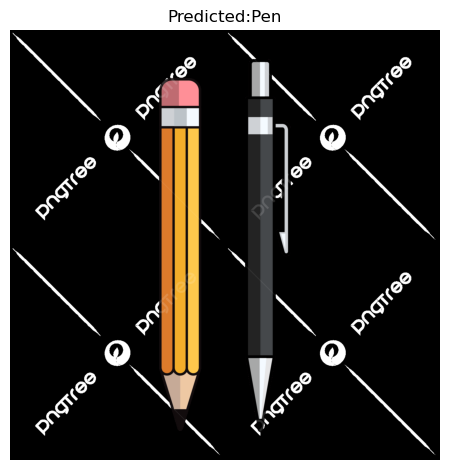


Prediction Results:
Most likely: Pen (99.81% confidence)

All class probabilities:
Crayon: 0.0%
Marker: 0.0%
Pen: 99.8%
Wooden_Pencil: 0.2%


In [147]:
# Prediction Stage 4: Pencil and Pen 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Test_images/Example_2.png',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


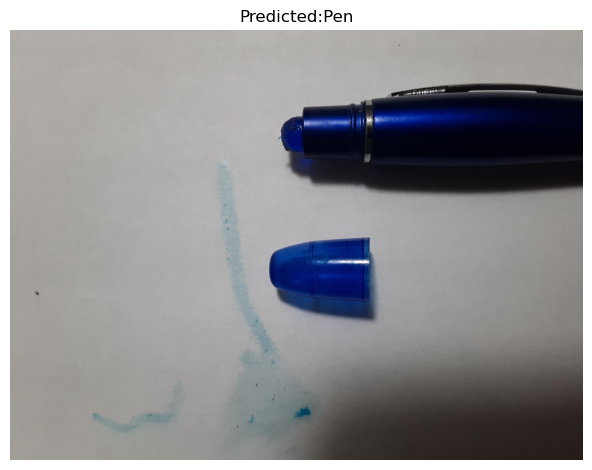


Prediction Results:
Most likely: Pen (97.18% confidence)

All class probabilities:
Crayon: 1.0%
Marker: 1.8%
Pen: 97.2%
Wooden_Pencil: 0.1%


In [148]:
# Prediction Stage 5: Pen 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/ue2ilgr1xau21.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


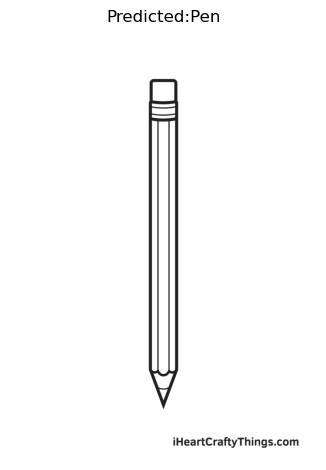


Prediction Results:
Most likely: Pen (90.39% confidence)

All class probabilities:
Crayon: 3.3%
Marker: 1.1%
Pen: 90.4%
Wooden_Pencil: 5.2%


In [149]:
# Prediction Stage 6: Pencil 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Pencil-DRAWING-–-STEP-9.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


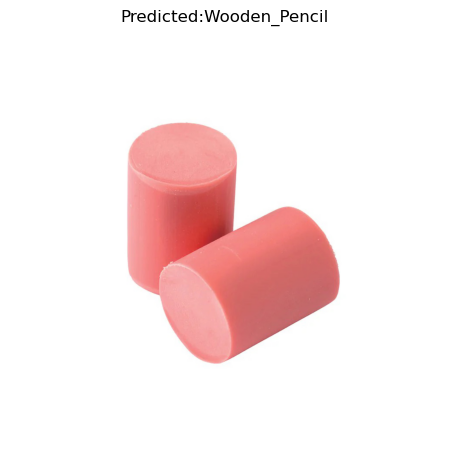


Prediction Results:
Most likely: Wooden_Pencil (52.49% confidence)

All class probabilities:
Crayon: 22.8%
Marker: 14.7%
Pen: 10.1%
Wooden_Pencil: 52.5%


In [150]:
# Prediction Stage 7: Pencil  
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Documents/Ohto_2_Eraser_Refill.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


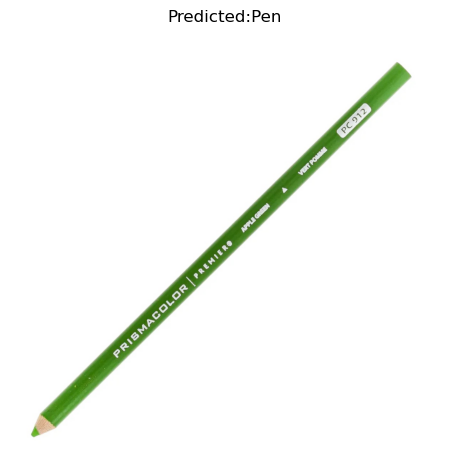


Prediction Results:
Most likely: Pen (96.34% confidence)

All class probabilities:
Crayon: 0.2%
Marker: 1.9%
Pen: 96.3%
Wooden_Pencil: 1.5%


In [151]:
# Prediction Stage 8: Pencil 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Documents/prismacolor-premier-colored-pencil-apple-green-912-883395_1200x1200_crop_center.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


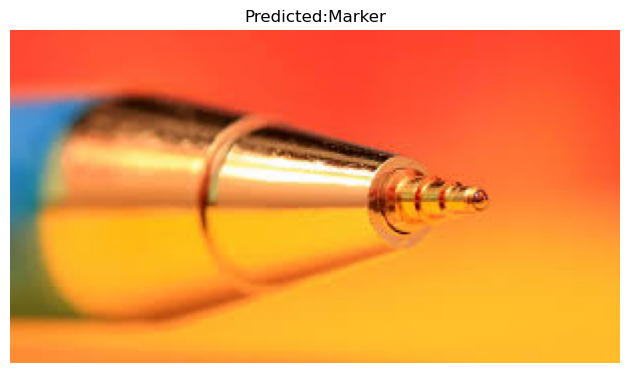


Prediction Results:
Most likely: Marker (70.82% confidence)

All class probabilities:
Crayon: 27.5%
Marker: 70.8%
Pen: 1.5%
Wooden_Pencil: 0.2%


In [152]:
# Prediction Stage 9: Pen 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Test_images/imagesp.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


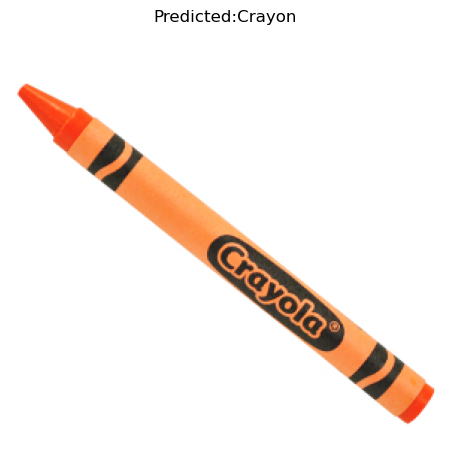


Prediction Results:
Most likely: Crayon (63.31% confidence)

All class probabilities:
Crayon: 63.3%
Marker: 29.0%
Pen: 5.3%
Wooden_Pencil: 2.4%


In [153]:
# Prediction Stage 10: Crayon 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/g05-0551401-8110bg.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


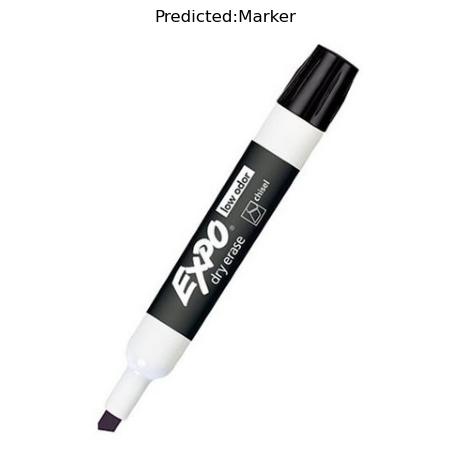


Prediction Results:
Most likely: Marker (58.05% confidence)

All class probabilities:
Crayon: 19.9%
Marker: 58.0%
Pen: 11.6%
Wooden_Pencil: 10.4%


In [154]:
# Prediction Stage 11: Marker 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/expo-2-low-odor-dry-erase-marker-chisel-tip-black.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


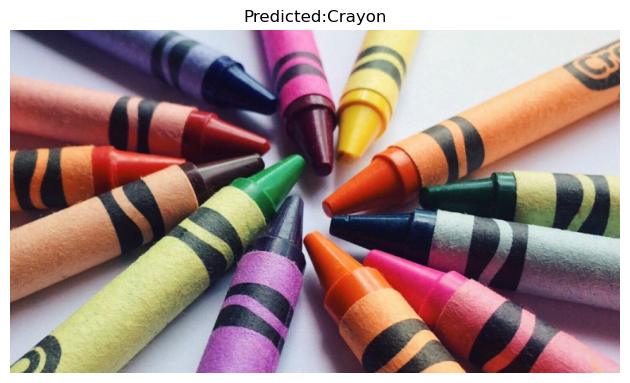


Prediction Results:
Most likely: Crayon (76.66% confidence)

All class probabilities:
Crayon: 76.7%
Marker: 7.5%
Pen: 15.5%
Wooden_Pencil: 0.4%


In [155]:
# Prediction Stage 12: Crayon 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/website-feature---national-crayon-day--march-31.png',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


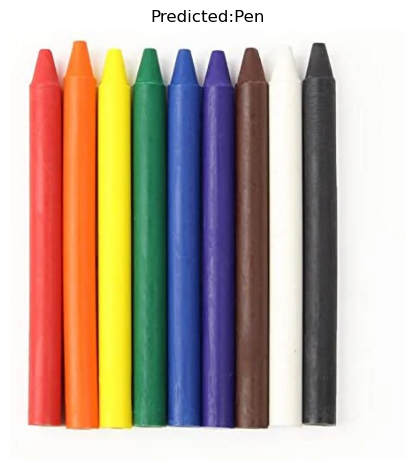


Prediction Results:
Most likely: Pen (88.03% confidence)

All class probabilities:
Crayon: 1.4%
Marker: 1.9%
Pen: 88.0%
Wooden_Pencil: 8.6%


In [156]:
# Prediction Stage 13: Crayons 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Multi/tough_crayon.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


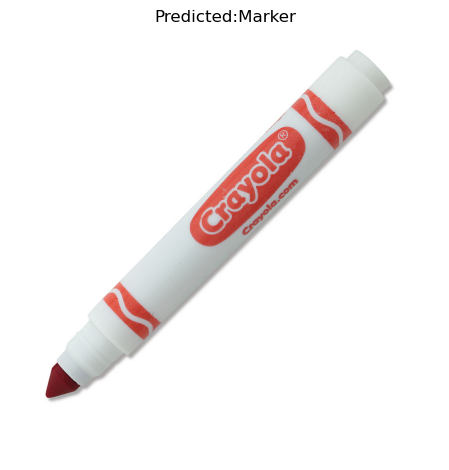


Prediction Results:
Most likely: Marker (62.61% confidence)

All class probabilities:
Crayon: 12.1%
Marker: 62.6%
Pen: 21.5%
Wooden_Pencil: 3.9%


In [157]:
# Prediction Stage 14: Marker 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Multi/markertest2.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


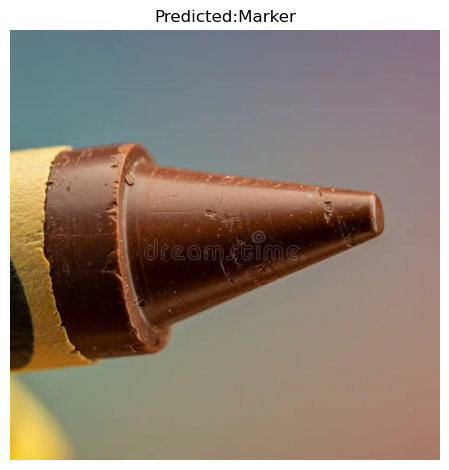


Prediction Results:
Most likely: Marker (53.27% confidence)

All class probabilities:
Crayon: 2.6%
Marker: 53.3%
Pen: 35.5%
Wooden_Pencil: 8.7%


In [158]:
# Prediction Stage 15: Crayon 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Test_images/brown-crayon-tip-close-up-macro-study-dramatically-lit-shot-reveals-intricate-texture-subtle-imperfections-s-370061149.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


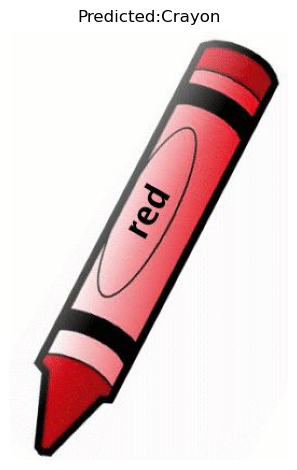


Prediction Results:
Most likely: Crayon (60.67% confidence)

All class probabilities:
Crayon: 60.7%
Marker: 10.4%
Pen: 22.8%
Wooden_Pencil: 6.1%


In [159]:
# Prediction Stage 16: Crayon 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Test_images/e46903c1ffd0ca36ec2033452bae250c.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


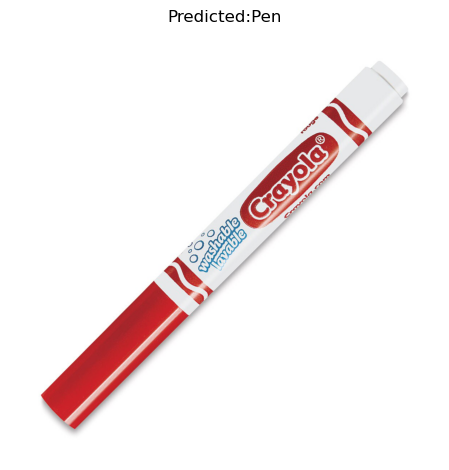


Prediction Results:
Most likely: Pen (50.62% confidence)

All class probabilities:
Crayon: 23.0%
Marker: 25.8%
Pen: 50.6%
Wooden_Pencil: 0.5%


In [160]:
# Prediction Stage 17: Marker 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Test_images/9071247343529.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


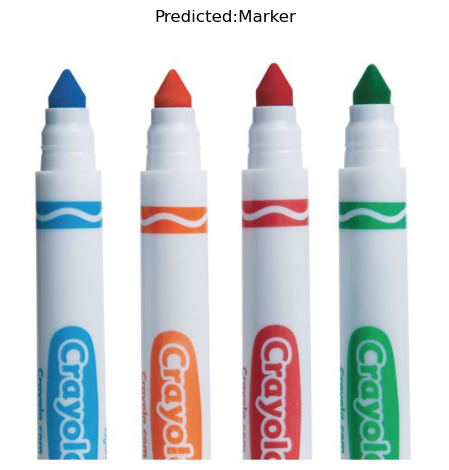


Prediction Results:
Most likely: Marker (42.33% confidence)

All class probabilities:
Crayon: 40.9%
Marker: 42.3%
Pen: 8.5%
Wooden_Pencil: 8.3%


In [161]:
# Prediction Stage 18: Marker 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Test_images/SWSC080901R13cob.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


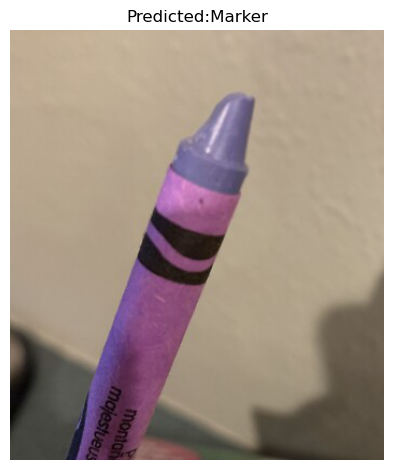


Prediction Results:
Most likely: Marker (96.36% confidence)

All class probabilities:
Crayon: 2.0%
Marker: 96.4%
Pen: 0.5%
Wooden_Pencil: 1.2%


In [162]:
# Prediction Stage 19: Crayon 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Test_images/s-l400.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


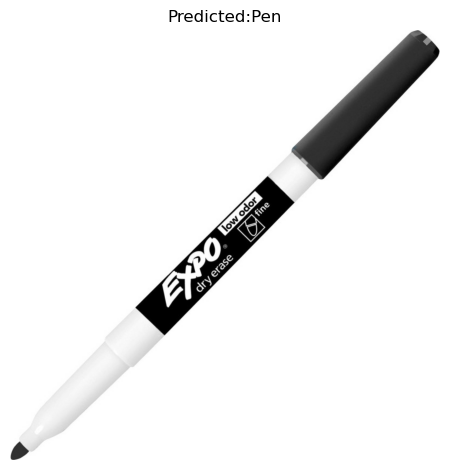


Prediction Results:
Most likely: Pen (52.83% confidence)

All class probabilities:
Crayon: 12.1%
Marker: 30.5%
Pen: 52.8%
Wooden_Pencil: 4.6%


In [164]:
# Prediction Stage 20: Marker 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Test_images/expo-low-oder-fine-tip-marker-black.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


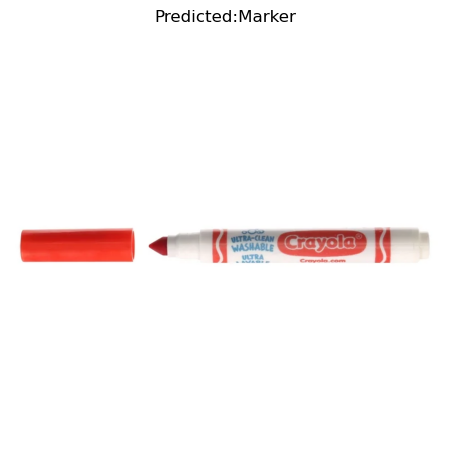


Prediction Results:
Most likely: Marker (46.34% confidence)

All class probabilities:
Crayon: 28.0%
Marker: 46.3%
Pen: 21.0%
Wooden_Pencil: 4.7%


In [165]:
# Prediction Stage 21: Marker 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Test_images/fc5ffca8-576d-4b7e-85b8-221be599f8df.53d482852a63b7b0ddb3ce301879f552.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")
